In [1]:
# demonstrate a simple computation graph

import torch
import torch.nn.functional as F
import torch

y = torch.tensor([1.0])
x1 = torch.tensor([1.1])
w1 = torch.tensor([2.2], requires_grad=True)
b = torch.tensor([3.3], requires_grad=True)
z = w1 * x1 + b
a = torch.sigmoid(z)
loss = F.binary_cross_entropy(a, y)

grad_L_w1 = torch.autograd.grad(loss, w1, retain_graph=True)
grad_L_b = torch.autograd.grad(loss, b, retain_graph=True)
print(f'grad_L_w1: {grad_L_w1}')
print(f'grad_L_b: {grad_L_b}')

# all the gradients can be autocomputed using the backward method
loss.backward()
print(f'w1.grad: {w1.grad}')
print(f'b.grad: {b.grad}')

ModuleNotFoundError: No module named 'torch'

In [2]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()

        self.layers = torch.nn.Sequential(
            
            #1st hidden layer
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20, num_outputs)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits
    
model = NeuralNetwork(50, 3)
print(model)

# How many trainable parameters does the model have?
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} total parameters.')

print(model.layers[0].weight)
print(model.layers[0].weight.shape)

torch.manual_seed(123)
X = torch.rand(1, 50)

with torch.no_grad():
    out = torch.softmax(model(X), dim=1)

print(out)


NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)
2213 total parameters.
Parameter containing:
tensor([[-0.0149,  0.1028, -0.0482,  ..., -0.0515,  0.0117,  0.0650],
        [-0.0050,  0.0219,  0.0076,  ..., -0.1090,  0.0711, -0.0728],
        [-0.1171, -0.1394, -0.0676,  ..., -0.0806, -0.1242, -0.1361],
        ...,
        [-0.0472, -0.0998, -0.0618,  ...,  0.0957,  0.1247,  0.0653],
        [ 0.0447,  0.0650,  0.0329,  ..., -0.0497, -0.0594,  0.0748],
        [ 0.0652,  0.0161,  0.1386,  ...,  0.0787, -0.1404,  0.0925]],
       requires_grad=True)
torch.Size([30, 50])
tensor([[0.3476, 0.3307, 0.3217]])


In [3]:
# Understanding data loaders

X_train = torch.tensor(
    [
        [-1.2, 3.1],
        [-0.9, 2.9],
        [-0.5, 2.6],
        [2.3, 1.1],
        [2.7, -1.5]
    ]
)

y_train = torch.tensor([0, 0, 0, 1, 1])

X_test = torch.tensor(
    [
        [-1.1, 3.0],
        [2.4, 1.0]
    ]
)

y_test = torch.tensor([0, 1])

from torch.utils.data import Dataset

class ToyDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.label = y

    def __getitem__(self, index):
        return self.features[index], self.label[index]
    
    def __len__(self):
        return self.label.shape[0]
    
train_dataset = ToyDataset(X_train, y_train)
test_dataset = ToyDataset(X_test, y_test)

# Instantiate a data loader
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 2,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 2,
    shuffle=False,
    num_workers=0
)

# iterate over the training dataloader
for idx, (x,y) in enumerate(train_loader):
    print(f'batch {idx + 1}:')
    print(x)
    print(y)

batch 1:
tensor([[ 2.3000,  1.1000],
        [-0.5000,  2.6000]])
tensor([1, 0])
batch 2:
tensor([[-1.2000,  3.1000],
        [-0.9000,  2.9000]])
tensor([0, 0])
batch 3:
tensor([[ 2.7000, -1.5000]])
tensor([1])


In [4]:
def compute_accuracy(model, data_loader):
    
    model = model.eval()
    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(data_loader):
        with torch.no_grad():
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum((predictions == labels).float())
            total_examples += labels.shape[0]

    return (correct / total_examples).item()

In [5]:
# Train the neural network

import torch.nn.functional as F

torch.manual_seed(123)
model = NeuralNetwork(num_inputs=2, num_outputs=2)

# Count number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} total parameters.')

optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (features, labels) in enumerate(train_loader):
        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         ### LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
        f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
        f" | Train Loss: {loss:.2f}")

model.eval()

with torch.no_grad():
    outputs = model(X_train)

print(outputs)

torch.set_printoptions(sci_mode=False)
probas = torch.softmax(outputs, dim=1)
print(probas)

predictions = torch.argmax(probas, dim=1)
print(predictions)

# How many did we get right in the training set?
predictions == y_train
torch.sum(predictions == y_train)

print(compute_accuracy(model, train_loader))
print(compute_accuracy(model, test_loader))

752 total parameters.
Epoch: 001/005 | Batch 000/003 | Train Loss: 0.75
Epoch: 001/005 | Batch 001/003 | Train Loss: 0.90
Epoch: 001/005 | Batch 002/003 | Train Loss: 0.65
Epoch: 002/005 | Batch 000/003 | Train Loss: 0.28
Epoch: 002/005 | Batch 001/003 | Train Loss: 0.92
Epoch: 002/005 | Batch 002/003 | Train Loss: 0.00
Epoch: 003/005 | Batch 000/003 | Train Loss: 0.04
Epoch: 003/005 | Batch 001/003 | Train Loss: 0.00
Epoch: 003/005 | Batch 002/003 | Train Loss: 0.32
Epoch: 004/005 | Batch 000/003 | Train Loss: 0.00
Epoch: 004/005 | Batch 001/003 | Train Loss: 0.01
Epoch: 004/005 | Batch 002/003 | Train Loss: 0.00
Epoch: 005/005 | Batch 000/003 | Train Loss: 0.00
Epoch: 005/005 | Batch 001/003 | Train Loss: 0.01
Epoch: 005/005 | Batch 002/003 | Train Loss: 0.00
tensor([[ 3.8888, -4.6334],
        [ 3.3716, -4.0287],
        [ 2.6617, -3.1935],
        [-2.3332,  2.2271],
        [-3.5767,  3.3827]])
tensor([[    0.9998,     0.0002],
        [    0.9994,     0.0006],
        [    0.9971

CPU: 1000x1000
CPU Time: 0.007337093353271484
GPU: 1000x1000
GPU Time: 0.0009984970092773438
CPU: 1500x1500
CPU Time: 0.0189974308013916
GPU: 1500x1500
GPU Time: 0.04862093925476074
CPU: 2000x2000
CPU Time: 0.030144214630126953
GPU: 2000x2000
GPU Time: 0.0019996166229248047
CPU: 2500x2500
CPU Time: 0.07636189460754395
GPU: 2500x2500
GPU Time: 0.004000425338745117
CPU: 3000x3000
CPU Time: 0.14993548393249512
GPU: 3000x3000
GPU Time: 0.050066471099853516
CPU: 3500x3500
CPU Time: 0.15700244903564453
GPU: 3500x3500
GPU Time: 0.006998538970947266
CPU: 4000x4000
CPU Time: 0.24368572235107422
GPU: 4000x4000
GPU Time: 0.01599740982055664
CPU: 4500x4500
CPU Time: 0.45079803466796875
GPU: 4500x4500
GPU Time: 0.1252288818359375
CPU: 5000x5000
CPU Time: 0.4917726516723633
GPU: 5000x5000
GPU Time: 0.09709692001342773
CPU: 5500x5500
CPU Time: 0.7360680103302002
GPU: 5500x5500
GPU Time: 0.08285188674926758
CPU: 6000x6000
CPU Time: 0.9349780082702637
GPU: 6000x6000
GPU Time: 0.07869505882263184
CPU: 6

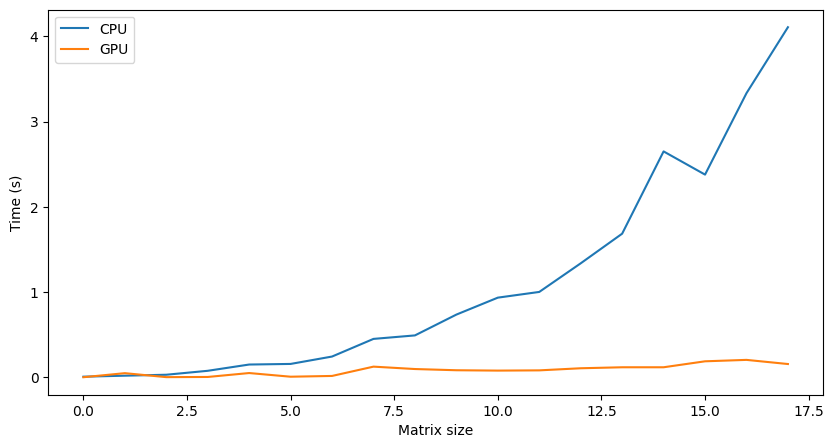

In [8]:
# Do the following in a loop:
# Start with a tensor_size 1000 and go upto 90000
# Create a tensor of size tensor_size x tensor_size
# Do a matrix multiplication on the CPU and measure the time.
# Create copies of the tensor to the GPU, and delete the original tensor.
# Do a matrix multiplication on the GPU and measure the time.
# Store the CPU and GPU times in separate lists.
# When the iteration is done, generate a plot of the cpu and gpu times vs tensor_size.

import matplotlib.pyplot as plt
import time

cpu_times = []
gpu_times = []

for tensor_size in range(1000, 10000, 500):
    test_tensor_1 = torch.rand(tensor_size, tensor_size)

    start_time = time.time()
    print(f'CPU: {tensor_size}x{tensor_size}')
    cpu_product = test_tensor_1.matmul(test_tensor_1)
    end_time = time.time()
    cpu_times.append(end_time - start_time)
    print(f'CPU Time: {end_time - start_time}')

    xpu_tensor_1 = test_tensor_1.to('xpu')

    del test_tensor_1

    start_time = time.time()
    print(f'GPU: {tensor_size}x{tensor_size}')
    xpu_product = xpu_tensor_1.matmul(xpu_tensor_1)
    end_time = time.time()
    gpu_times.append(end_time - start_time)
    print(f'GPU Time: {end_time - start_time}')

    del xpu_tensor_1
    del xpu_product

plt.figure(figsize=(10, 5))
plt.plot(cpu_times, label='CPU')
plt.plot(gpu_times, label='GPU')
plt.xlabel('Matrix size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()



In [4]:
import torch
tensor = torch.tensor([1.0, 2.0]).to("xpu")